In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import chi2_contingency

from bin import utils

In [35]:
# gdata = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/RNA/spatial.filtered.guide.bin100.h5')
gdata = sc.read_h5ad('./RNA/spatial.combined.bin100.h5')
# gdata = gdata[:, gdata.var_names.str.startswith('sg')]
# fdata = sc.read_h5ad('./RNA/spatial.combined.bin100.h5')
# fdata = sc.read_h5ad('./RNA/spatial.combined.clustered.h5')
fdata = sc.read_h5ad('/home/wpy/stereoseq/20240702-Exclusive/he_annotate_merge.h5')

In [36]:
gdata.var_names[gdata.var_names.str.startswith('sg')]

Index(['sgAckr3_1', 'sgAckr3_2', 'sgBatf_1', 'sgBatf_2', 'sgBcl2_1',
       'sgBcl2_2', 'sgBcl2l11_1', 'sgBcl2l11_2', 'sgBhlhe40_1', 'sgBhlhe40_2',
       'sgCcr10_1', 'sgCcr10_2', 'sgCcr1_1', 'sgCcr1_2', 'sgCcr2_1',
       'sgCcr2_2', 'sgCcr4_1', 'sgCcr4_2', 'sgCcr5_1', 'sgCcr5_2', 'sgCcr6_1',
       'sgCcr6_2', 'sgCcr7_1', 'sgCcr7_2', 'sgCd74_1', 'sgCd74_2', 'sgCxcr1_1',
       'sgCxcr1_2', 'sgCxcr2_1', 'sgCxcr3_1', 'sgCxcr3_2', 'sgCxcr4_1',
       'sgCxcr4_2', 'sgCxcr5_1', 'sgCxcr5_2', 'sgCxcr6_1', 'sgDdit4_1',
       'sgDdit4_2', 'sgElob_1', 'sgElob_2', 'sgFos_1', 'sgFos_2', 'sgFoxp1_1',
       'sgFoxp1_2', 'sgGpr35_1', 'sgGpr35_2', 'sgHopx_1', 'sgHopx_2',
       'sgJun_1', 'sgJund_1', 'sgJund_2', 'sgKlf2_2', 'sgNon-targeting_1',
       'sgNon-targeting_2', 'sgNon-targeting_3', 'sgNon-targeting_4',
       'sgNon-targeting_5', 'sgNon-targeting_6', 'sgTgif1_1', 'sgTgif1_2',
       'sgTox_1', 'sgTox_2', 'sgYbx1_1', 'sgYbx1_2'],
      dtype='object')

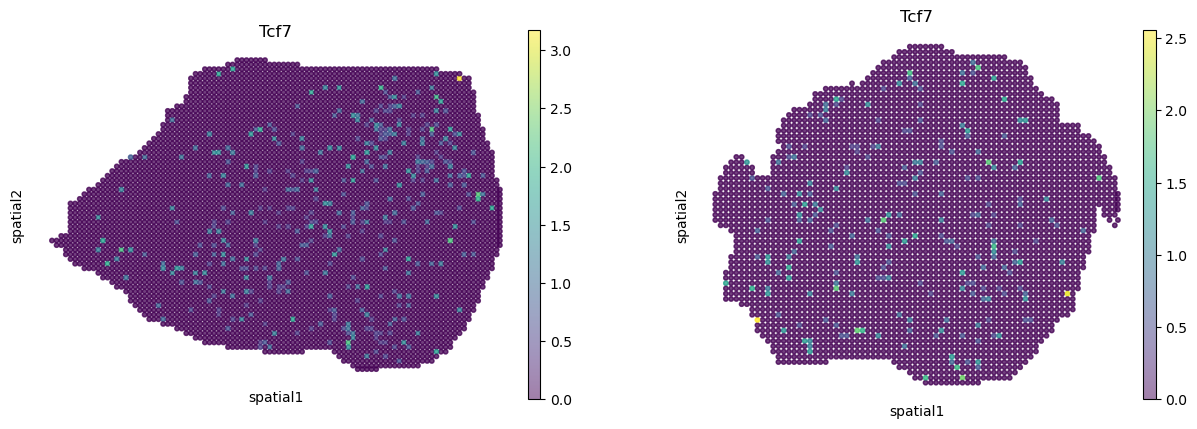

In [23]:
sq.pl.spatial_scatter(fdata, color='Tcf7', shape=None, size=40, alpha=0.5, library_key='marker')
sns.despine(left=True, bottom=True)

In [4]:
def align_rna_guide_data(fdata, gdata):
    fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
    fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
    gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]
    fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]

    common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
    fdata = fdata[common_bins].copy()
    gdata = gdata[common_bins].copy()

    gdata.obs["cluster"] = fdata.obs["cluster"].tolist()
    return fdata, gdata
fdata, gdata = align_rna_guide_data(fdata, gdata)

In [5]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


# Diffine Score Tissue

In [6]:
fibro_genes = ['Tpm1', 'Acta1', 'Myh4', 'Tnnt3']
tumor_genes = ['Spp1', 'C1qa', 'H2-K1', 'Lgals1', 'S100a6']

sc.tl.score_genes(fdata, fibro_genes, score_name='fibro_score')
sc.tl.score_genes(fdata, tumor_genes, score_name='tumor_score')

fdata.obs['tumor_score'] = (fdata.obs['tumor_score'] - np.mean(fdata.obs['tumor_score'])) / np.std(fdata.obs['tumor_score'])
fdata.obs['fibro_score'] = (fdata.obs['fibro_score'] - np.mean(fdata.obs['fibro_score'])) / np.std(fdata.obs['fibro_score'])

fdata.obs['tissue'] = (fdata.obs['tumor_score'] > fdata.obs['fibro_score']).map({True: 'tumor', False: 'fibro'})

fdata.obs.loc[(fdata.obs.marker == 'A') & (fdata.obsm['spatial'][:, 1] < 4000), 'tissue'] = 'lymph node'
fdata.obs.loc[(fdata.obs.marker == 'B') & (fdata.obsm['spatial'][:, 1] > 6500), 'tissue'] = 'lymph node'
fdata.obs.tissue.value_counts()

gdata.obs['tissue'] = fdata.obs['tissue'].tolist()

In [7]:
gdata.obs['tissue_type'] = fdata.obs['tissue_type'].tolist()

# Specific Distribution

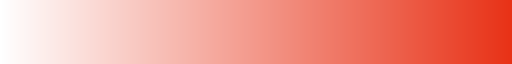

In [13]:
from types import new_class
from matplotlib.colors import LinearSegmentedColormap

# colors = ['#1f4fa1', '#ffffff', '#e83217']
colors = ['#ffffff', '#e83217']
n_bins = 256
new_cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)
new_cmap

In [14]:
p_dict = {}
ntc_name = 'sgnon-targeting'
gdata_ = gdata[gdata.obs.marker == 'A'].copy()
# gdata_ = gdata.copy()
cdf = pd.concat([pd.DataFrame(gdata_.X, index=gdata_.obs_names, columns=gdata_.var_names), gdata_.obs[['tissue_type']]], axis=1)
mdf = cdf.groupby(['tissue_type']).sum().melt(ignore_index=False).reset_index()

for tissue in mdf.tissue_type.unique():
    p_dict[tissue] = []
    for guide in mdf.variable.unique():
        if guide == ntc_name: continue
        int_df = mdf[(mdf.tissue_type == tissue) & np.isin(mdf.variable, [guide, ntc_name])][['variable', 'value']].set_index('variable')
        res_df = mdf[(mdf.tissue_type != tissue) & np.isin(mdf.variable, [guide, ntc_name])].set_index('tissue_type')[['variable', 'value']].groupby('variable').sum()
        chi_df = pd.concat([int_df, res_df], axis=1)
        if chi_df.loc[guide].sum() == 0:
            p_dict[tissue].append(1)
        else:
            chi_df.columns = ['tissue_' + str(tissue), 'rest']
            pval = chi2_contingency(chi_df)[1]
            p_dict[tissue].append(pval)
chi_df = pd.DataFrame(p_dict, index=gdata_.var_names[:-1]).T

l2fc_dict = {}

pdf = mdf.set_index(['tissue_type', 'variable'])['value'].unstack()
pdf = pdf.div(pdf.sum(axis=0), axis=1)
pdf = pdf.div(pdf[ntc_name], axis=0).loc[:, pdf.columns != ntc_name]
# pdf = pdf

annot_df = chi_df.map(lambda x: '***' if x < 0.05 else ('**' if x < 0.1 else ('*' if x < 0.5 else '')))
plt.figure(figsize=(1, 6))
chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35"]
tf_list = pdf.columns[~pdf.columns.isin(chemokine_list)].tolist()

# heatmap = sns.heatmap(np.log2(pdf.T).loc[chemokine_list + tf_list, :], annot=annot_df.T, fmt='s', cmap=new_cmap, vmax=0.5, vmin=-0.5)
plot_df = np.log2(pdf.T).loc[chemokine_list + tf_list, :].melt()
heatmap = sns.scatterplot(x=plot_df.value, y=plot_df.variable, s=plot_df.index * 100, alpha=0.7, color='black', marker='s')

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Log2(Fold Change)\n~ NTC')
plt.xticks(rotation=25, ha='right')
plt.yticks(fontsize=8)
plt.xlabel('')

plt.ylabel('Perturbation')
plt.title('')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/proportion_heatmap.pdf', bbox_inches='tight', format='pdf')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'variable'

<Figure size 100x600 with 0 Axes>

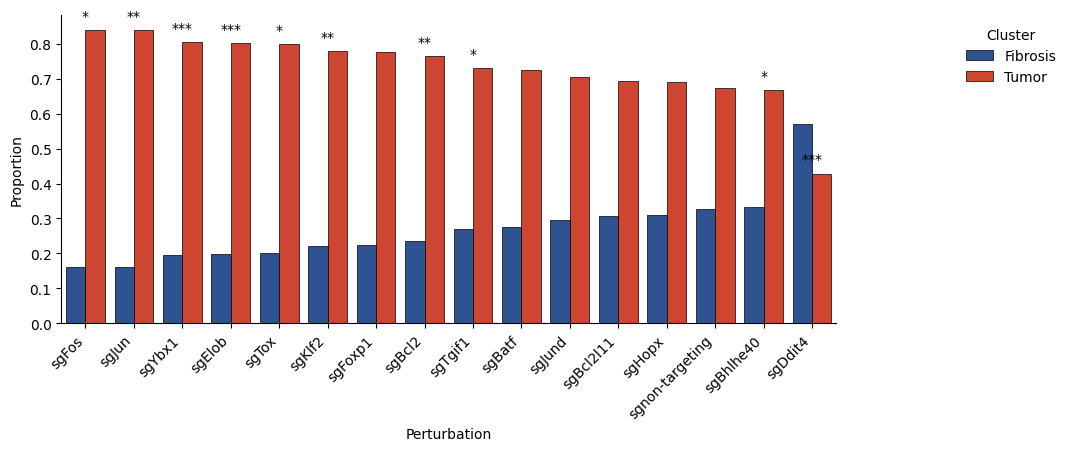

In [16]:
ntc_name = 'sgnon-targeting'

gdata_ = gdata[gdata.obs.marker == 'A'].copy()

chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35"]

# gdata_ = gdata.copy()
cdf = pd.concat([pd.DataFrame(gdata_.X, index=gdata_.obs_names, columns=gdata_.var_names), gdata_.obs[['tissue_type']]], axis=1)
mdf = cdf.groupby(['tissue_type']).sum().melt(ignore_index=False).reset_index()
pdf = mdf.set_index(['tissue_type', 'variable'])['value'].unstack()
pdf = pdf.div(pdf.sum(axis=0), axis=1)

pdf = pdf.T.sort_values(by='Tumor', ascending=False).T
plot_guides = pdf.columns[~pdf.columns.isin(chemokine_list)]

plot_df = pdf[plot_guides].melt(ignore_index=False).reset_index()
plot_df['marker'] = 'A'

# gdata_ = gdata[gdata.obs.marker == 'B'].copy()
# # gdata_ = gdata.copy()
# cdf = pd.concat([pd.DataFrame(gdata_.X, index=gdata_.obs_names, columns=gdata_.var_names), gdata_.obs[['tissue_type']]], axis=1)
# mdf = cdf.groupby(['tissue_type']).sum().melt(ignore_index=False).reset_index()
# pdf = mdf.set_index(['tissue_type', 'variable'])['value'].unstack()
# pdf = pdf.div(pdf.sum(axis=0), axis=1)
# print(pdf.columns[pdf.loc['Tumor'].argmax()])

# plot_df_b = pdf[plot_guides].melt(ignore_index=False).reset_index()
# plot_df_b['marker'] = 'B'
# join_df = pd.concat([plot_df, plot_df_b], axis=0)
join_df = plot_df

join_df['sig'] = ['*', '*', '**', '**', '***', '***', '***', '***', '*', '*', '**', '**', '', '',
                  '**', '**', '*', '*', '', '', '', '', '', '', '', '', '', '', '*', '*', '***', '***']

# Create bar plot
plt.figure(figsize=(10, 4))
ax = sns.barplot(x='variable', y='value', hue='tissue_type', data=join_df, palette=['#1f4fa1', '#e83217'], edgecolor='black', linewidth=0.5, errorbar=('ci', 95))

# Add jittered dots
# sns.stripplot(x='variable', y='value', hue='tissue_type', data=join_df,
#               dodge=True, alpha=0.9, size=4, jitter=0.4, palette='RdBu_r', legend=False, edgecolor='black', linewidth=0.5)
plt.legend(loc='upper right', title='Cluster', frameon=False, bbox_to_anchor=(1.3, 1))
sns.despine()
plt.xticks(rotation=45, ha='right')

# plt.hlines(0.8, len(plot_guides)-3, len(plot_guides)-2, color='black', linestyle='-', linewidth=2)
# plt.vlines(len(plot_guides)-3, 0.78, 0.8, color='black', linestyle='-', linewidth=2)
# plt.vlines(len(plot_guides)-2, 0.78, 0.8, color='black', linestyle='-', linewidth=2)
# plt.text(len(plot_guides)-2.5, 0.82, '*', ha='center', va='bottom', fontsize=10)

for i, guide in join_df.iterrows():
    if i % 2 == 1:
        plt.text(i // 2, guide['value'] + 0.02, f'{guide['sig']:s}', ha='center', va='bottom')

plt.xlabel('Perturbation')
plt.ylabel('Proportion')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/guide_distribution_fibro_tumor.pdf', bbox_inches='tight', format='pdf')
plt.show()


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


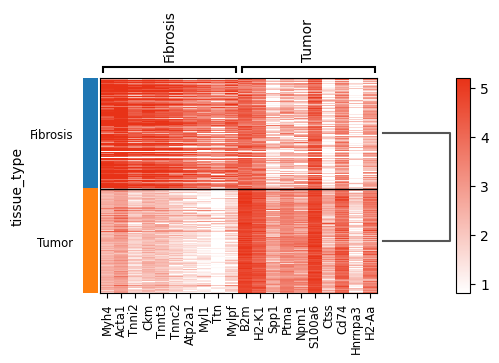

In [18]:
# fdata_ = fdata[fdata.obs.marker == 'A'].copy()
# sc.tl.rank_genes_groups(fdata_, 'tissue_type', method='t-test')
sc.pl.rank_genes_groups_heatmap(fdata_, n_genes=10, figsize=(5, 3), values_to_plot='logfoldchanges', cmap=new_cmap,
                                vmax=5.2, vmin=0.8, save='fibro_tumor_deg_heatmap.pdf')
plt.show()

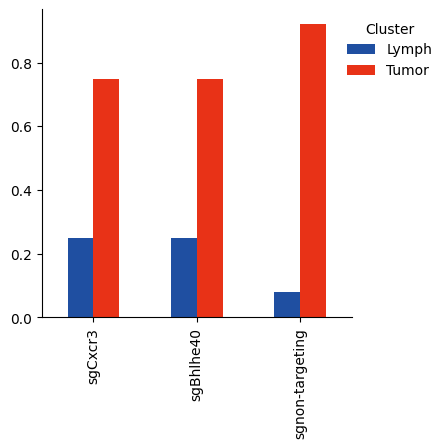

In [29]:
lymph_data_a = gdata[(gdata.obs.marker == 'A') & (gdata.obsm['spatial'][:, 1] < 4000)].copy()
lymph_data_a[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)
tumor_data_a = gdata[(gdata.obs.marker == 'A') & (gdata.obsm['spatial'][:, 1] > 4000)].copy()
tumor_data_a[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)

lymph_data_b = gdata[(gdata.obs.marker == 'B') & (gdata.obsm['spatial'][:, 1] > 6500)].copy()
lymph_data_b[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)
tumor_data_b = gdata[(gdata.obs.marker == 'B') & (gdata.obsm['spatial'][:, 1] < 6500)].copy()
tumor_data_b[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)

# plot_df = pd.DataFrame({
#     'Lymph': np.concatenate([lymph_data_a[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0),
#                               lymph_data_b[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)]),
#     'Tumor': np.concatenate([tumor_data_a[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0),
#                               tumor_data_b[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)])
# }, index=["sgCxcr3", "sgBhlhe40", 'sgnon-targeting'] * 2)
plot_df = pd.DataFrame({
    'Lymph': lymph_data_a[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0),
    'Tumor': tumor_data_a[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)
}, index=["sgCxcr3", "sgBhlhe40", 'sgnon-targeting'])
plot_df = plot_df.div(plot_df.sum(axis=1), axis=0)
plot_df.plot.bar(figsize=(4, 4), cmap=new_cmap)

# for i, guide in enumerate(['sgCxcr3', 'sgBhlhe40', 'sgnon-targeting']):
#     plt.text(i-0.15, plot_df.iloc[i, 0], f'{plot_df.iloc[i, 0]:.2f}', ha='center', va='bottom')
#     plt.text(i+0.15, plot_df.iloc[i, 1], f'{plot_df.iloc[i, 1]:.2f}', ha='center', va='bottom')

plt.legend(loc='upper right', title='Cluster', frameon=False, bbox_to_anchor=(1.3, 1))

sns.despine()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('guide_distribution_lymph_tumor.pdf', bbox_inches='tight', format='pdf')
plt.show()

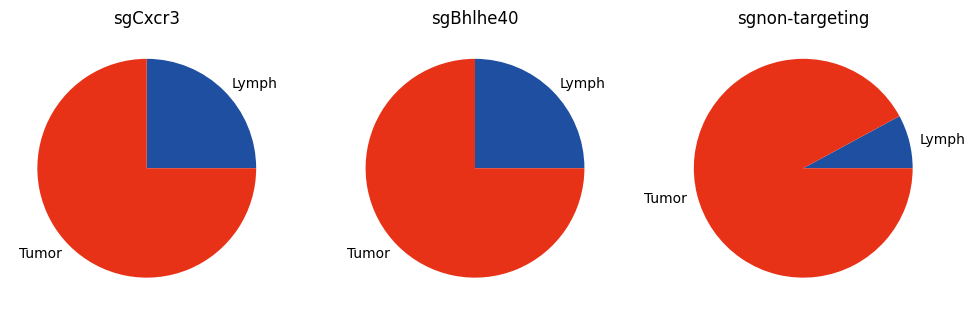

In [34]:
lymph_data_a = gdata[(gdata.obs.marker == 'A') & (gdata.obsm['spatial'][:, 1] < 4000)].copy()
lymph_counts = lymph_data_a[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)
tumor_data_a = gdata[(gdata.obs.marker == 'A') & (gdata.obsm['spatial'][:, 1] > 4000)].copy()
tumor_counts = tumor_data_a[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)

lymph_data_b = gdata[(gdata.obs.marker == 'B') & (gdata.obsm['spatial'][:, 1] > 6500)].copy()
lymph_counts_b = lymph_data_b[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)
tumor_data_b = gdata[(gdata.obs.marker == 'B') & (gdata.obsm['spatial'][:, 1] < 6500)].copy()
tumor_counts_b = tumor_data_b[:, ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']].X.toarray().sum(axis=0)

guides = ["sgCxcr3", "sgBhlhe40", 'sgnon-targeting']
plt.figure(figsize=(12, 4))

# 第一个饼图 - sgCxcr3
plt.subplot(131)
plt.pie([lymph_counts[0], tumor_counts[0]], labels=['Lymph', 'Tumor'], autopct='', colors=['#1f4fa1', '#e83217'])
plt.title('sgCxcr3')

# 第二个饼图 - sgBhlhe40
plt.subplot(132)
plt.pie([lymph_counts[1], tumor_counts[1]], labels=['Lymph', 'Tumor'], autopct='', colors=['#1f4fa1', '#e83217'])
plt.title('sgBhlhe40')

# 第三个饼图 - sgnon-targeting
plt.subplot(133)
plt.pie([lymph_counts[2], tumor_counts[2]], labels=['Lymph', 'Tumor'], autopct='', colors=['#1f4fa1', '#e83217'])
plt.title('sgnon-targeting')

plt.savefig('guide_distribution_pie_charts.pdf', bbox_inches='tight', format='pdf')
plt.show()

/tmp/ipykernel_74783/3158456787.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdf = cdf.groupby(['marker', 'cluster']).sum().melt(ignore_index=False).reset_index()


tumor
lymph node
fibro


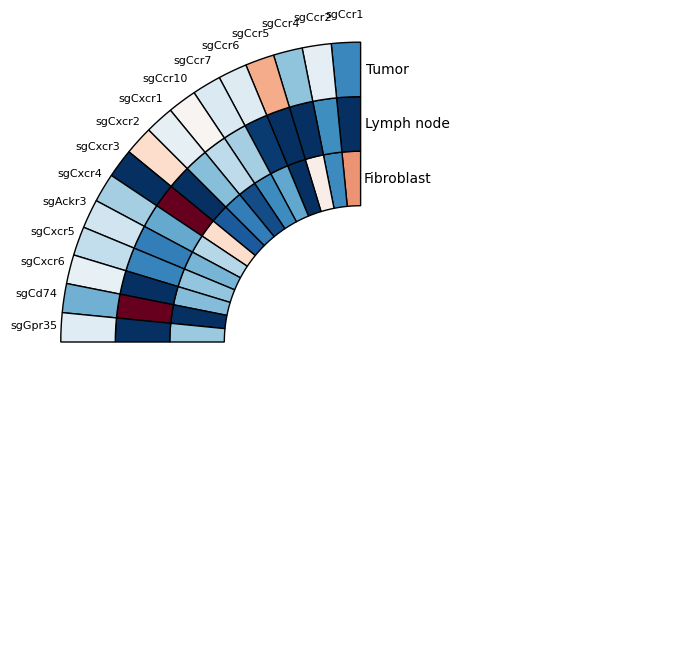

In [31]:
cdf = pd.concat([pd.DataFrame(gdata.X, index=gdata.obs_names, columns=gdata.var_names), gdata.obs[['marker', 'cluster']]], axis=1)
mdf = cdf.groupby(['marker', 'cluster']).sum().melt(ignore_index=False).reset_index()

MARKER = 'A'
p_dict = {}

ntc_name = 'sgnon-targeting'
gdata_ = gdata[gdata.obs.marker == 'A'].copy()
cdf = pd.concat([pd.DataFrame(gdata_.X, index=gdata_.obs_names, columns=gdata_.var_names), gdata_.obs[['tissue']]], axis=1)
mdf = cdf.groupby(['tissue']).sum().melt(ignore_index=False).reset_index()

for tissue in mdf.tissue.unique():
    p_dict[tissue] = []
    for guide in mdf.variable.unique():
        if guide == ntc_name: continue
        int_df = mdf[(mdf.tissue == tissue) & np.isin(mdf.variable, [guide, ntc_name])][['variable', 'value']].set_index('variable')
        res_df = mdf[(mdf.tissue != tissue) & np.isin(mdf.variable, [guide, ntc_name])].set_index('tissue')[['variable', 'value']].groupby('variable').sum()
        chi_df = pd.concat([int_df, res_df], axis=1)
        chi_df.columns = ['tissue_' + str(tissue), 'rest']
        pval = chi2_contingency(chi_df)[1]
        p_dict[tissue].append(pval)
chi_df = pd.DataFrame(p_dict, index=gdata_.var_names[:-1]).T

l2fc_dict = {}

pdf = mdf.set_index(['tissue', 'variable'])['value'].unstack()
pdf = pdf.div(pdf.sum(axis=0), axis=1)
pdf = pdf.div(pdf[ntc_name], axis=0).loc[:, pdf.columns != ntc_name]
# pdf = pdf

annot_df = chi_df.map(lambda x: '***' if x < 0.01 else ('**' if x < 0.05 else ('*' if x < 0.1 else '')))
# plt.figure(figsize=(20, 8))
# heatmap = sns.heatmap(pdf, annot=annot_df, fmt='s', cmap='RdBu_r')

# colorbar = heatmap.collections[0].colorbar
# colorbar.set_label('FC of proportion ~ NTC')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Guide')
# plt.title('Cluster specific proportion with Chi2 contingency')
# plt.show()

chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35"]

pdf = pdf.loc[:, chemokine_list]

fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'polar'})
cmap = plt.colormaps['RdBu_r']

sorted_guides = pdf.columns

# min_val = np.min(pdf.values) / 2
# max_val = np.max(pdf.values) / 2
min_val = 0.5
max_val = 2

radius = 1
width = 0.4

angle = 0.5 * np.pi / len(pdf.columns)
angles = np.linspace(0.5 * np.pi + angle / 2, 1 * np.pi + angle / 2, len(pdf.columns), endpoint=False)

plt.text(0.5 * np.pi-0.02, 1.6, 'Lymph node', ha='left', va='center', fontsize=10)
plt.text(0.5 * np.pi-0.02, 2.0, 'Tumor', ha='left', va='center', fontsize=10)
plt.text(0.5 * np.pi-0.02, 1.2, 'Fibroblast', ha='left', va='center', fontsize=10)

for tissue in ['None'] * 0 + list(pdf.index):
    if tissue != 'None':
        guide_colors = cmap(((pdf.loc[tissue, sorted_guides].values - min_val) / (max_val - min_val)))
        bars = ax.bar(x=angles, height=width, width=angle, color=guide_colors, edgecolor='black', bottom=radius, alpha=1)  # 添加黑色网框
        # for angle in angles:
            # ax.text(angle, radius + 0.5, annot_df.loc[tissue, sorted_guides[angles.tolist().index(angle)]], ha='center', va='center', fontsize=8)
    else: 
        bars = ax.bar(x=angles, height=width, width=angle, color='none', edgecolor='black', bottom=radius)  # 添加黑色网框
    radius = radius + width
for tissue in list(pdf.index)[::-1]:
    print(tissue)

ax.spines['polar'].set_visible(False)  # 去除边框
ax.set_xticks(angles, sorted_guides, rotation=0, ha='center', fontsize=8)
ax.set_yticks([])
ax.grid(False)  # 去除grid线

# plt.xlim([0.5 * np.pi, 2 * np.pi])
# plt.ylim([0, 1])
plt.rcParams['pdf.fonttype']=42
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.savefig("./plots/sgCR_proportion_radar.pdf", format="pdf", bbox_inches='tight')

/tmp/ipykernel_74783/3541302772.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdf = cdf.groupby(['marker', 'cluster']).sum().melt(ignore_index=False).reset_index()


tumor
lymph node
fibro


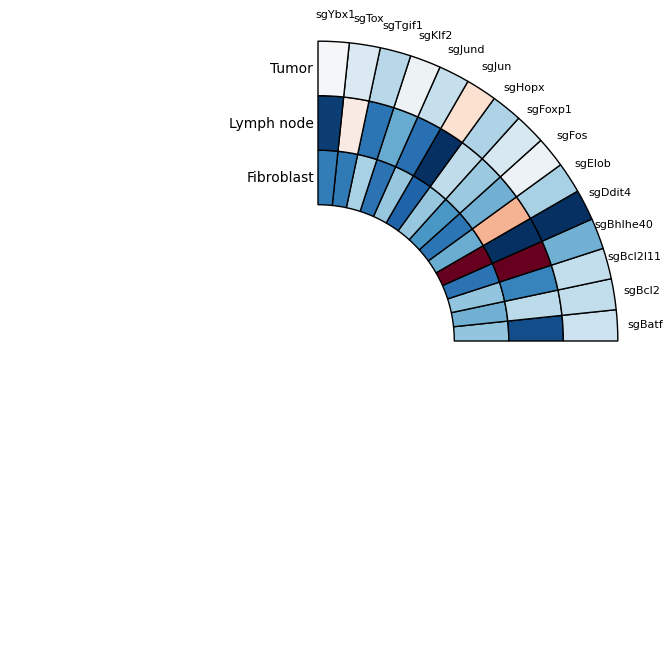

In [38]:
cdf = pd.concat([pd.DataFrame(gdata.X, index=gdata.obs_names, columns=gdata.var_names), gdata.obs[['marker', 'cluster']]], axis=1)
mdf = cdf.groupby(['marker', 'cluster']).sum().melt(ignore_index=False).reset_index()

MARKER = 'A'
p_dict = {}

ntc_name = 'sgnon-targeting'
gdata_ = gdata[gdata.obs.marker == 'A'].copy()
cdf = pd.concat([pd.DataFrame(gdata_.X, index=gdata_.obs_names, columns=gdata_.var_names), gdata_.obs[['tissue']]], axis=1)
mdf = cdf.groupby(['tissue']).sum().melt(ignore_index=False).reset_index()

for tissue in mdf.tissue.unique():
    p_dict[tissue] = []
    for guide in mdf.variable.unique():
        if guide == ntc_name: continue
        int_df = mdf[(mdf.tissue == tissue) & np.isin(mdf.variable, [guide, ntc_name])][['variable', 'value']].set_index('variable')
        res_df = mdf[(mdf.tissue != tissue) & np.isin(mdf.variable, [guide, ntc_name])].set_index('tissue')[['variable', 'value']].groupby('variable').sum()
        chi_df = pd.concat([int_df, res_df], axis=1)
        chi_df.columns = ['tissue_' + str(tissue), 'rest']
        pval = chi2_contingency(chi_df)[1]
        p_dict[tissue].append(pval)
chi_df = pd.DataFrame(p_dict, index=gdata_.var_names[:-1]).T

l2fc_dict = {}

pdf = mdf.set_index(['tissue', 'variable'])['value'].unstack()
pdf = pdf.div(pdf.sum(axis=0), axis=1)
pdf = pdf.div(pdf[ntc_name], axis=0).loc[:, pdf.columns != ntc_name]
# pdf = pdf

annot_df = chi_df.map(lambda x: '***' if x < 0.01 else ('**' if x < 0.05 else ('*' if x < 0.1 else '')))
# plt.figure(figsize=(20, 8))
# heatmap = sns.heatmap(pdf, annot=annot_df, fmt='s', cmap='RdBu_r')

# colorbar = heatmap.collections[0].colorbar
# colorbar.set_label('FC of proportion ~ NTC')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Guide')
# plt.title('Cluster specific proportion with Chi2 contingency')
# plt.show()

chemokine_list = ["sgCcr1", "sgCcr2", "sgCcr4", "sgCcr5", "sgCcr6",
    "sgCcr7", "sgCcr10", "sgCxcr1", "sgCxcr2", "sgCxcr3", "sgCxcr4",
    "sgAckr3", "sgCxcr5", "sgCxcr6", "sgCd74", "sgGpr35", 'sgnon-targeting']

pdf = pdf.loc[:, ~pdf.columns.isin(chemokine_list)]

fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'polar'})
cmap = plt.colormaps['RdBu_r']

sorted_guides = pdf.columns

# min_val = np.min(pdf.values) / 2
# max_val = np.max(pdf.values) / 2
min_val = 0.5
max_val = 2

radius = 1
width = 0.4

angle = 0.5 * np.pi / len(pdf.columns)
angles = np.linspace(0 * np.pi + angle / 2, 0.5 * np.pi + angle / 2, len(pdf.columns), endpoint=False)

plt.text(0.5 * np.pi+0.02, 1.6, 'Lymph node', ha='right', va='center', fontsize=10)
plt.text(0.5 * np.pi+0.02, 2.0, 'Tumor', ha='right', va='center', fontsize=10)
plt.text(0.5 * np.pi+0.02, 1.2, 'Fibroblast', ha='right', va='center', fontsize=10)

for tissue in ['None'] * 0 + list(pdf.index):
    if tissue != 'None':
        guide_colors = cmap(((pdf.loc[tissue, sorted_guides].values - min_val) / (max_val - min_val)))
        bars = ax.bar(x=angles, height=width, width=angle, color=guide_colors, edgecolor='black', bottom=radius, alpha=1)  # 添加黑色网框
        # for angle in angles:
            # ax.text(angle, radius + 0.5, annot_df.loc[tissue, sorted_guides[angles.tolist().index(angle)]], ha='center', va='center', fontsize=8)
    else: 
        bars = ax.bar(x=angles, height=width, width=angle, color='none', edgecolor='black', bottom=radius)  # 添加黑色网框
    radius = radius + width
for tissue in list(pdf.index)[::-1]:
    print(tissue)

ax.spines['polar'].set_visible(False)  # 去除边框
ax.set_xticks(angles, sorted_guides, rotation=0, ha='center', fontsize=8)
ax.set_yticks([])
ax.grid(False)  # 去除grid线

# plt.xlim([0.5 * np.pi, 2 * np.pi])
# plt.ylim([0, 1])
plt.rcParams['pdf.fonttype']=42
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.savefig("./plots/sgTF_proportion_radar.pdf", format="pdf", bbox_inches='tight')

# Cluster

/tmp/ipykernel_60171/20639392.py:7: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1],
/tmp/ipykernel_60171/20639392.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1],


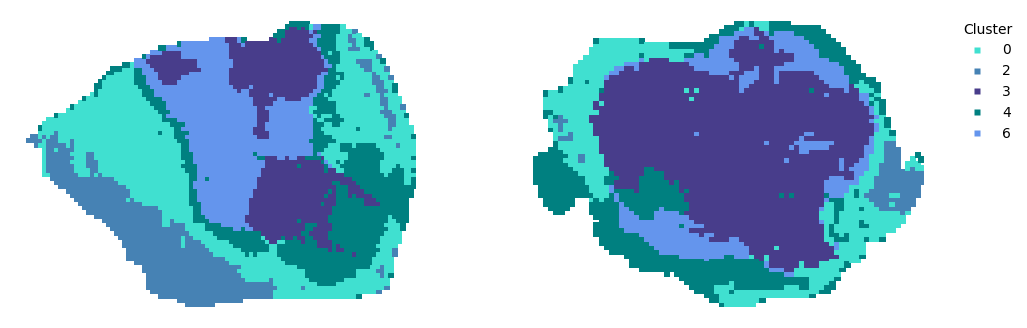

In [12]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

colors = ['turquoise', 'steelblue', 'darkslateblue', 'teal', 'cornflowerblue', 'wheat', 'lightpink']

MARKER = 'A'
plot_data = fdata[fdata.obs['marker'] == MARKER]
sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1],
                hue=plot_data.obs['cluster'], s=16, marker='s',
                palette=colors, ax=ax[0], edgecolor='none', legend=False, alpha=1)

MARKER = 'B'
plot_data = fdata[fdata.obs['marker'] == MARKER]
sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1],
                hue=plot_data.obs['cluster'], s=22, marker='s',
                palette=colors, ax=ax[1], edgecolor='none', alpha=1)
plt.legend(loc='upper right', title='Cluster', frameon=False, bbox_to_anchor=(1.2, 1))

sns.despine(ax=ax[0], left=True, bottom=True)
sns.despine(ax=ax[1], left=True, bottom=True)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('/home/wpy/stereoseq/20240702-Exclusive/plots/Exclusive_cluster_plot.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [78]:
fdata.obs.dtypes

marker          category
n_counts           int64
n_genes            int64
x                  int64
y                  int64
_scvi_batch         int8
_scvi_labels        int8
cluster         category
coord_x            int64
coord_y            int64
dtype: object

In [73]:
sc.tl.rank_genes_groups(fdata, 'cluster', method='t-test')

In [74]:
pval_cutoff = 0.01
top_n = 50

result = fdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv('../20240502-SPACseq/DEG.csv', index=False, sep="\t")
top_genes_df

,Gene,Log2FoldChange,padj,score,Cluster
0,Acta1,2.152356,0.000000e+00,47.133980,0
1,Tnnt3,2.085449,1.906315e-301,40.914185,0
2,Tnni2,2.218070,2.381219e-297,40.590530,0
3,Myh1,2.333670,6.040882e-285,40.137760,0
4,Atp2a1,2.152122,4.131945e-286,39.788445,0
...,...,...,...,...,...
245,Itm2b,0.637082,3.464708e-164,29.063190,6
246,Snrpg,0.998271,2.599404e-158,28.971802,6
247,Sh3bgrl3,0.675972,1.390615e-164,28.917782,6
248,Fkbp1a,0.680716,3.659642e-161,28.693403,6


In [82]:
top_genes_df[top_genes_df.Cluster == '0'][~top_genes_df[top_genes_df.Cluster == '0'].Gene.isin(top_genes_df[top_genes_df.Cluster == '2'].Gene.tolist())]



,Gene,Log2FoldChange,padj,score,Cluster
19,Gpx3,1.176725,3.561022e-153,28.149494,0
22,Gas6,1.781749,3.989387e-147,27.798611,0
25,Camk1d,0.788772,1.669988e-135,26.277048,0
29,Igfbp4,1.232855,3.913208e-128,25.544096,0
31,Dcn,1.354405,9.229161e-119,24.558479,0
33,C3,0.969808,6.992185e-115,24.038809,0
35,H19,1.394894,6.363559e-110,23.549665,0
36,Filip1l,0.837286,1.850623e-107,23.230631,0
37,Cryab,1.341196,6.020696e-105,22.936058,0
38,Pi16,1.631356,1.095305e-102,22.785694,0


In [182]:
!sshpass -p wang2024 ssh wpy@172.16.10.103 "mamba run -n gsea python ~/stereoseq/20240502-SPACseq/enrich.py"

Gene               object
Log2FoldChange    float64
padj              float64
score             float64
Cluster            object
dtype: object
/home/wpy/stereoseq/20240502-SPACseq/bin/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
Enrichment analysis for list 0 completed successfully: 675
Enrichment analysis for list 1 completed successfully: 461
Enrichment analysis for list 2 completed successfully: 1176
Enrichment analysis for list 3 completed successfully: 1008
Enrichment analysis for list 4 completed successfully: 1173



In [69]:
for i in [0, 1, 2, 3, 4]:
    enr = pd.read_csv(f"~/stereoseq/20240502-SPACseq/GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False)
    results = results[results["Adjusted P-value"] < 0.1]
    results = results.loc[:, ["Term", "Genes", "Adjusted P-value"]]
    results["Cluster"] = i
    results["Gene Counts"] = results["Genes"].str.split(";").apply(len)
    results["Term"] = results["Term"].str.split("R-HSA").str[0]
    results['Term'] = results['Term'].str.split('\(GO').str[0]
    results = results.groupby("Cluster", as_index=False).apply(lambda x: x.sort_values(by='Adjusted P-value')).reset_index(drop=True)
    if not i: go_df = results
    else: go_df = pd.concat([go_df, results], axis=0)
#go_df.to_csv('~/stereoseq/20240502-SPACseq/GO/Reactome.csv', index=None, sep='\t')
go_df

<>:9: SyntaxWarning: invalid escape sequence '\('
<>:9: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_39430/3300357501.py:9: SyntaxWarning: invalid escape sequence '\('
  results['Term'] = results['Term'].str.split('\(GO').str[0]
/tmp/ipykernel_39430/3300357501.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = results.groupby("Cluster", as_index=False).apply(lambda x: x.sort_values(by='Adjusted P-value')).reset_index(drop=True)
/tmp/ipykernel_39430/3300357501.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pas

,Term,Genes,Adjusted P-value,Cluster,Gene Counts
0,Striated Muscle Contraction,MYBPC1;MYBPC2;DES;ACTN3;MYL1;TPM2;TNNC2;TPM1;T...,5.301969e-22,0,12
1,Muscle Contraction,RYR1;MYBPC1;MYBPC2;ACTN3;TPM2;TPM1;TNNC2;NEB;A...,7.789969e-19,0,16
2,Muscle Contraction,RYR1;TPM2;TPM1;PGAM2;KLHL41;TRDN;TTN;MYH1;DES;...,3.487166e-17,0,13
3,Striated Muscle Contraction,RYR1;TPM1;TNNC2;PGAM2;TNNT3;TCAP;TNNI2;ATP1A2;...,3.555396e-14,0,10
4,Myofibril Assembly,TPM1;TNNT3;TCAP;CASQ1;KLHL41;TTN,2.547826e-07,0,6
...,...,...,...,...,...
113,Cellular Response To Chemical Stress,COX8A;SEM1;ATOX1,9.708963e-02,4,3
114,Oxygen-dependent Proline Hydroxylation Of Hypo...,SEM1;ELOB,9.763113e-02,4,2
115,Semaphorin Interactions,MYL6;TYROBP,9.763113e-02,4,2
116,Mitochondrial Transport,TSPO;SLC25A5,9.993518e-02,4,2


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

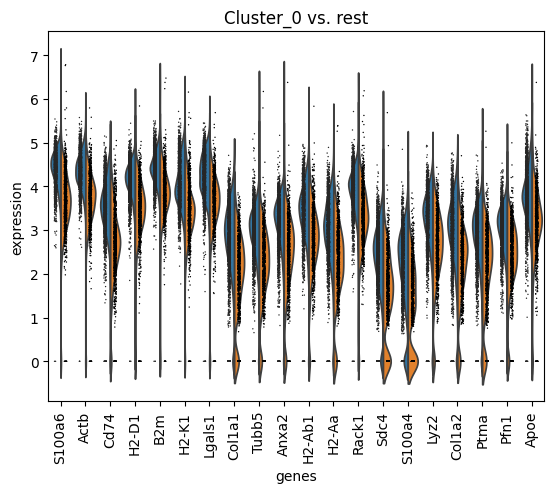

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


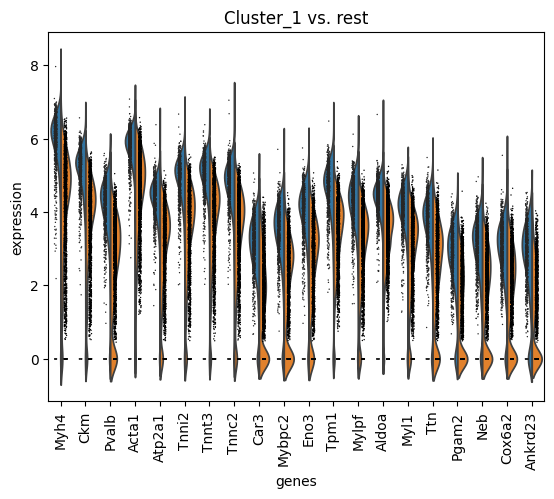

In [184]:
diff_data = fdata[np.isin(fdata.obs.cluster, ['Cluster_0', 'Cluster_1'])]
sc.tl.rank_genes_groups(diff_data, groupby='cluster', method='t-test')
sc.pl.rank_genes_groups_violin(diff_data, n_genes=20)


In [70]:
go_df.groupby('Cluster').head(10)

,Term,Genes,Adjusted P-value,Cluster,Gene Counts
0,Striated Muscle Contraction,MYBPC1;MYBPC2;DES;ACTN3;MYL1;TPM2;TNNC2;TPM1;T...,5.301969e-22,0,12
1,Muscle Contraction,RYR1;MYBPC1;MYBPC2;ACTN3;TPM2;TPM1;TNNC2;NEB;A...,7.789969e-19,0,16
2,Muscle Contraction,RYR1;TPM2;TPM1;PGAM2;KLHL41;TRDN;TTN;MYH1;DES;...,3.487166e-17,0,13
3,Striated Muscle Contraction,RYR1;TPM1;TNNC2;PGAM2;TNNT3;TCAP;TNNI2;ATP1A2;...,3.555396e-14,0,10
4,Myofibril Assembly,TPM1;TNNT3;TCAP;CASQ1;KLHL41;TTN,2.547826e-07,0,6
5,Sarcomere Organization,TPM1;TNNT3;TCAP;CASQ1;TTN,1.109818e-06,0,5
6,Actomyosin Structure Organization,TPM1;TNNT3;TCAP;CASQ1;KLHL41;TTN,3.649630e-06,0,6
7,Heart Contraction,TPM1;TCAP;ATP1A2;TTN;TRDN,4.565141e-06,0,5
8,Actin Filament Organization,ACTA1;TPM2;TPM1;TCAP;NEB;ALDOA;TTN,4.694602e-06,0,7
9,Skeletal Muscle Contraction,TNNC2;TNNT3;TCAP;TNNI2,8.011706e-06,0,4


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for

<Axes: xlabel='rank', ylabel='Cluster'>

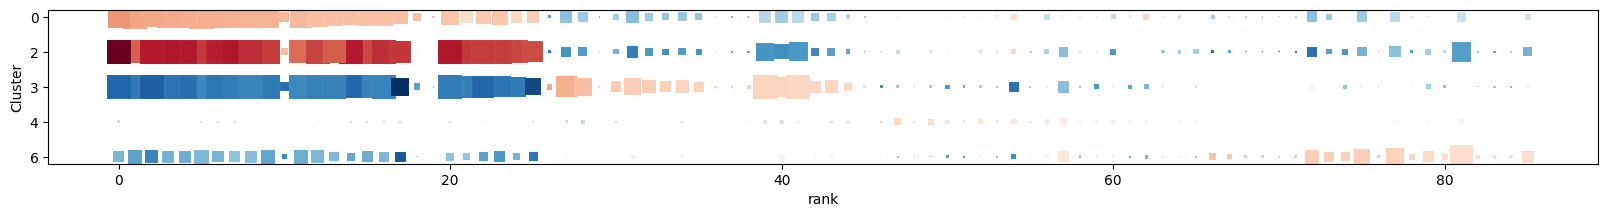

In [156]:
genes = top_genes_df.Gene.tolist()
expr_df = pd.DataFrame()
gene_to_rank = pd.DataFrame({
    'names': top_genes_df.Gene.unique().tolist(),
    'rank': list(range(top_genes_df.Gene.unique().shape[0]))
})
for cluster in top_genes_df.Cluster.unique():
    df = sc.get.rank_genes_groups_df(fdata, group=cluster)
    df = df[df.names.isin(genes)]
    df['Cluster'] = cluster
    df = df.merge(gene_to_rank, on='names', how='outer')
    expr_df = pd.concat([expr_df, df], axis=0)

# expr_df['rank'] = expr_df.groupby('Cluster').cumcount()

expr_df['-log10(p-value)'] = -np.log10(expr_df['pvals_adj'] + 1e-300)
plt.figure(figsize=(20, 2))
sns.scatterplot(data=expr_df, x='rank', y='Cluster',
                s=expr_df['-log10(p-value)'].tolist(), c=expr_df['logfoldchanges'].tolist(),
                cmap='RdBu_r', marker='s')

# sc.get.rank_genes_groups_df(fdata, group='0').head(5)

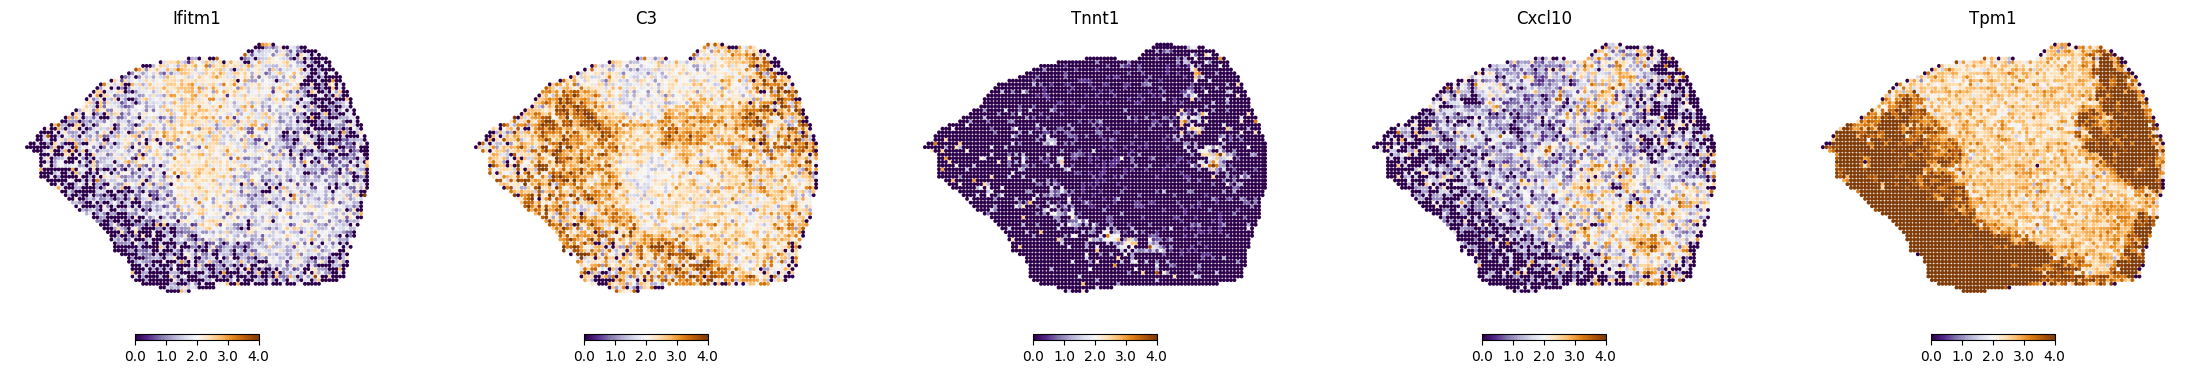

In [132]:
plot_data = fdata[fdata.obs['marker'] == 'A']

GENES = ['Ifitm1', 'C3', 'Tnnt1', 'Cxcl10', 'Tpm1']
# plt.figure(figsize=(4, 3))
_, ax = plt.subplots(1, 5, figsize=(28, 4))
for i, GENE in enumerate(GENES):
    scatter = sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1],
                              c=plot_data[:, GENE].X.toarray().flatten(), cmap='PuOr_r', s=8, edgecolor='none', alpha=1,
                              vmax=4, vmin=0, ax=ax[i])
    ax[i].set_title(GENE)
    cbar = plt.colorbar(scatter.collections[0], orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.ax.set_xticks([0, 1, 2, 3, 4], ['0.0', '1.0', '2.0', '3.0', '4.0'])

    sns.despine(left=True, bottom=True, ax=scatter)
    scatter.set_xlabel('')
    scatter.set_ylabel('')
    scatter.set_xticks([])
    scatter.set_yticks([])
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/signature_gene_expression.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
plot_data = fdata[fdata.obs['marker'] == 'A']

GENE = 'Ifitm3'
plt.figure(figsize=(4, 3))
scatter = sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1],
                          c=plot_data[:, GENE].X.toarray().flatten(), cmap='PuOr_r', s=8, edgecolor='none', alpha=1,
                          vmax=5, vmin=0)
plt.title(GENE)
cbar = plt.colorbar(scatter.collections[0], orientation='horizontal', fraction=0.02, pad=0.1)
cbar.ax.set_xticks([0, 2.5, 5])

sns.despine(left=True, bottom=True, ax=scatter)
scatter.set_xlabel('')
scatter.set_ylabel('')
scatter.set_xticks([])
scatter.set_yticks([])
plt.show()

In [168]:
fdata.obs['cluster'] = fdata.obs['cluster'].astype(str).map({
    '0': 'Cluster_0',
    '2': 'Cluster_1',
    '3': 'Cluster_2',
    '4': 'Cluster_3',
    '6': 'Cluster_4'
})
sc.tl.rank_genes_groups(fdata, groupby='cluster', method='t-test')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


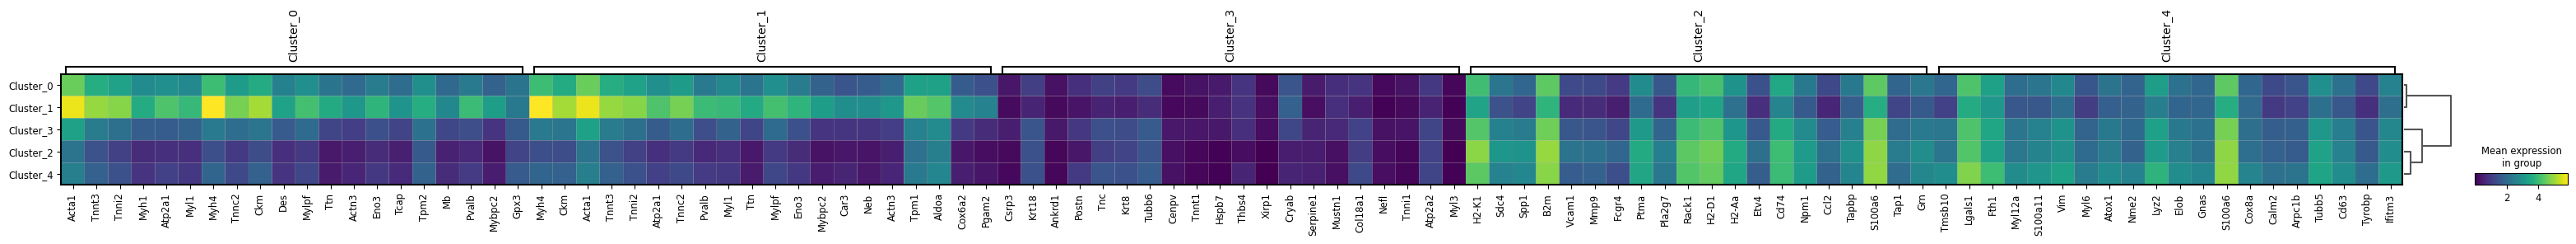

In [172]:
sc.pl.rank_genes_groups_matrixplot(fdata, n_genes=20)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


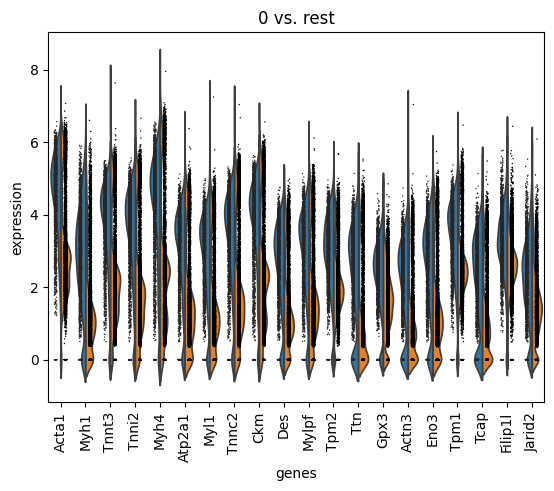

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


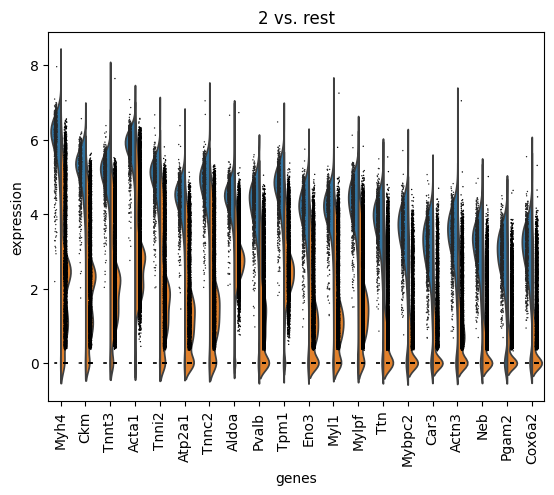

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


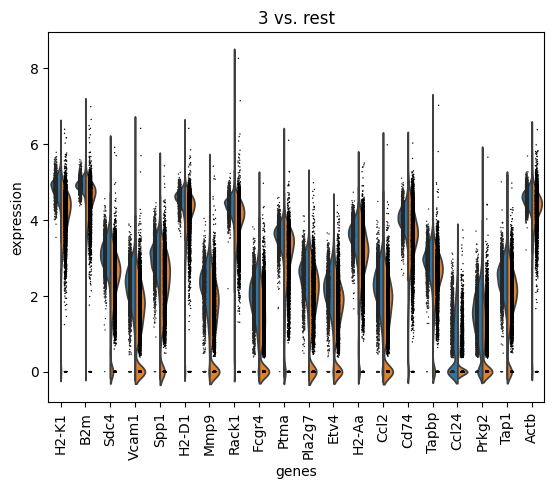

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


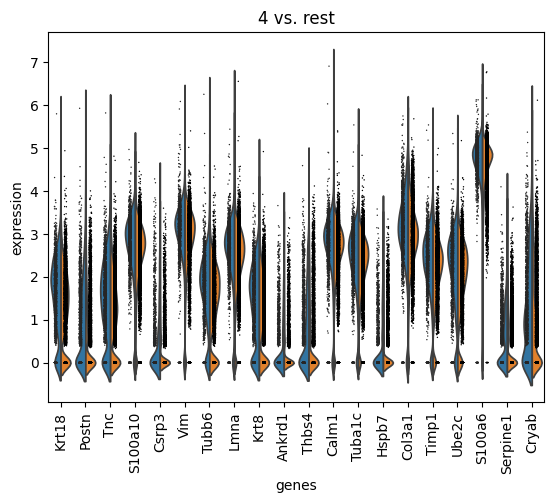

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


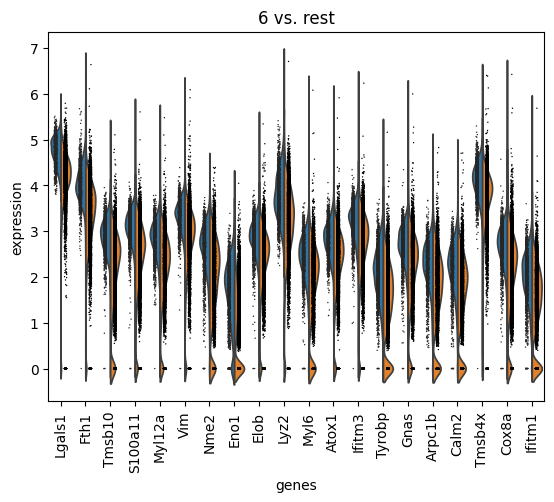

In [159]:
sc.pl.rank_genes_groups_violin(fdata, n_genes=20)

In [ ]:
expr_df['-log10(p-value)'] = -np.log10(expr_df['pval_adj'])

In [86]:
plot_df = top_genes_df.groupby('Cluster').head(10)




,Gene,Log2FoldChange,padj,score,Cluster
0,Acta1,2.152356,0.000000e+00,38.184605,0
1,Myh1,2.333670,5.216925e-298,37.135338,0
2,Tnnt3,2.085449,7.147721e-272,35.467590,0
3,Tnni2,2.218070,4.034392e-262,34.821022,0
4,Myh4,2.501357,3.559986e-255,34.352558,0
5,Atp2a1,2.152122,1.399624e-251,34.105637,0
6,Myl1,2.069996,6.127791e-249,33.922459,0
7,Tnnc2,2.181697,1.942047e-248,33.884533,0
8,Ckm,2.107621,1.516450e-247,33.820396,0
9,Des,1.971305,2.623789e-247,33.801083,0


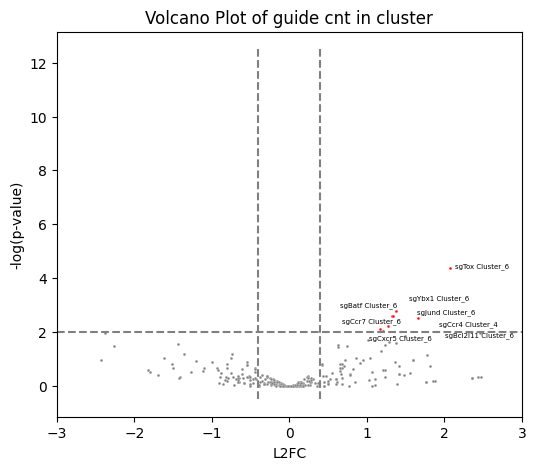

In [10]:
from adjustText import adjust_text
from igraph import palettes

plot_df = pd.DataFrame({
    'p-value': -np.log10(chi_df.melt().value.tolist()),
    'FC': list(np.log2(pdf.melt().value + 1e-9)),
    'Label': list((chi_df.melt().value < 0.01) & (np.abs(1 - pdf.melt().value) > 0.4))
}, index=[str(a) + ' Cluster_' + str(b) for a, b in zip(chi_df.melt().variable, chi_df.melt(ignore_index=False).index)])

plot_df = plot_df[plot_df.FC > np.log2(1e-6)]

# Create scatter plot
plt.figure(figsize=(6, 5))
scatter = sns.scatterplot(data=plot_df[~plot_df.Label], x='FC', y='p-value', color='grey', legend=False, s=4)
sns.scatterplot(data=plot_df[plot_df.Label], x='FC', y='p-value', color='red', legend=False, s=4, ax=scatter)


# Add labels for points where 'Label' is True
texts = []
for i, point in plot_df[plot_df['Label']].iterrows():
    texts.append(plt.text(point['FC'], point['p-value'], str(i), size=5))

scatter.hlines(y=-np.log10(0.01), xmin=-3, xmax=3, color='grey', linestyles='--')
scatter.vlines(x=-0.4, ymin=-0.5, ymax=12.5, color='grey', linestyles='--')
scatter.vlines(x=0.4, ymin=-0.5, ymax=12.5, color='grey', linestyles='--')

# Adjust text to prevent overlap
adjust_text(texts, expand_axes=True)

# Set x and y limits and labels
plt.xlim((-3, 3))
plt.xlabel('L2FC')
plt.ylabel('-log(p-value)')
plt.title('Volcano Plot of guide cnt in cluster')

plt.show()

# Interaction in cluster

In [42]:
from scipy.spatial import distance_matrix

fdata_A = fdata[fdata.obs['marker'] == 'A']
fdata_B = fdata[fdata.obs['marker'] == 'B']

lr_pairs = [
    ('Ccr7', 'Ccl19'), ('Cx3cr1', 'Cx3cl1'),
    ('Cxcr2', 'Cxcl1'), ('Ccrl2', 'Ccl19'), ('Cxcr4', 'Cxcl14'),
    ('Cxcr2', 'Cxcl5'), ('Cxcr3', 'Cxcl9'), ('Cxcr3', 'Cxcl10'),
    ('Cxcr4', 'Cxcl12'), ('Cxcr6', 'Cxcl16'), ('Ccr3', 'Ccl5'),
    ('Ccr4', 'Ccl5'), ('Ccr5', 'Ccl5'), ('Ackr2', 'Ccl1'), ('Ackr2', 'Ccl3'), ('Ackr2', 'Ccl4'),
    ('Ackr2', 'Ccl19'), ('Ackr2', 'Ccl5'), ('Ackr2', 'Ccl25'),
    ('Ackr2', 'Ccl11'), ('Ackr2', 'Ccl12'), ('Ackr2', 'Ccl27a'),
]

inter_df = pd.DataFrame()
for ligand, receptor in lr_pairs:
    lig_coords = fdata_A[fdata_A[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata_A[fdata_A[:, receptor].X > 0].obsm['spatial']

    dist_matrix = distance_matrix(lig_coords, rec_coords)

    if (dist_matrix < 30).sum() == 0: continue
    inter_vec = np.array((dist_matrix < 50).sum(axis=1))

    df = pd.DataFrame({
        'interaction': inter_vec,
        'cluster': fdata_A[fdata_A[:, ligand].X > 0].obs['tissue_type']
    }).groupby('cluster').sum().T
    df.index = [ligand + ' ~ ' + receptor]
    inter_df = pd.concat([inter_df, df], axis=0)

inter_df_B = pd.DataFrame()
for ligand, receptor in lr_pairs:
    lig_coords = fdata_B[fdata_B[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata_B[fdata_B[:, receptor].X > 0].obsm['spatial']

    dist_matrix = distance_matrix(lig_coords, rec_coords)

    if (dist_matrix < 30).sum() == 0: continue
    inter_vec = np.array((dist_matrix < 50).sum(axis=1))

    df = pd.DataFrame({
        'interaction': inter_vec,
        'cluster': fdata_B[fdata_B[:, ligand].X > 0].obs['tissue_type']
    }).groupby('cluster').sum().T
    df.index = [ligand + ' ~ ' + receptor]
    inter_df_B = pd.concat([inter_df_B, df], axis=0)

inter_df = inter_df + inter_df_B

/tmp/ipykernel_68319/152277467.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('cluster').sum().T
/tmp/ipykernel_68319/152277467.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('cluster').sum().T
/tmp/ipykernel_68319/152277467.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('cluster').sum().T
/tmp/ipykernel_68319/152277467.py:29: FutureWarning: The default of observed=False

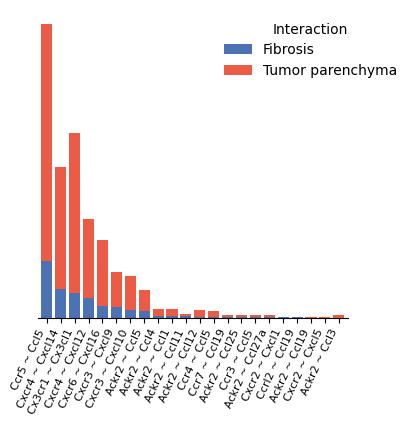

In [43]:
plot_df = inter_df
plot_df.columns = ['Fibrosis', 'Tumor parenchyma']
plot_df.sort_values(by='Fibrosis', ascending=False, inplace=True)
plot_df.plot.bar(stacked=True, figsize=(4, 4), cmap=new_cmap, width=0.8, alpha=0.8)
plt.legend(loc='upper right', title='Interaction', frameon=False, bbox_to_anchor=(1.2, 1), ncol=1)

sns.despine(left=True, bottom=False)
# plt.gca().set_yscale('log')
plt.xticks(rotation=65, ha='right', fontsize=8)
plt.yticks([])

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/Exclusive_interaction_cluster_proportion.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [32]:
from scipy.spatial import distance_matrix

fdata_A = fdata[fdata.obs['marker'] == 'A']
fdata_B = fdata[fdata.obs['marker'] == 'B']

lr_pairs = [
    ('Cxcr4', 'Cxcl14'),
    ('Cxcr4', 'Cxcl12')
]

inter_df = pd.DataFrame()
for ligand, receptor in lr_pairs:
    lig_coords = fdata_A[fdata_A[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata_A[fdata_A[:, receptor].X > 0].obsm['spatial']

    dist_matrix = distance_matrix(lig_coords, rec_coords)

    if (dist_matrix < 30).sum() == 0: continue
    inter_vec = np.array((dist_matrix < 50).sum(axis=1))

    df = pd.DataFrame({
        'interaction': inter_vec,
        'cluster': fdata_A[fdata_A[:, ligand].X > 0].obs['tissue_type']
    }).groupby('cluster').sum().T
    df.index = [ligand + ' ~ ' + receptor]
    inter_df = pd.concat([inter_df, df], axis=0)

inter_df_B = pd.DataFrame()
for ligand, receptor in lr_pairs:
    lig_coords = fdata_B[fdata_B[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata_B[fdata_B[:, receptor].X > 0].obsm['spatial']

    dist_matrix = distance_matrix(lig_coords, rec_coords)

    if (dist_matrix < 30).sum() == 0: continue
    inter_vec = np.array((dist_matrix < 50).sum(axis=1))

    df = pd.DataFrame({
        'interaction': inter_vec,
        'cluster': fdata_B[fdata_B[:, ligand].X > 0].obs['tissue_type']
    }).groupby('cluster').sum().T
    df.index = [ligand + ' ~ ' + receptor]
    inter_df_B = pd.concat([inter_df_B, df], axis=0)

inter_df = inter_df + inter_df_B

/tmp/ipykernel_67469/942431905.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('cluster').sum().T
/tmp/ipykernel_67469/942431905.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('cluster').sum().T
/tmp/ipykernel_67469/942431905.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('cluster').sum().T
/tmp/ipykernel_67469/942431905.py:41: FutureWarning: The default of observed=False

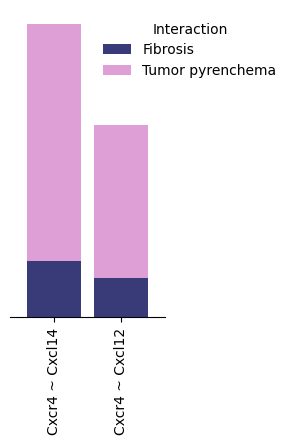

In [46]:
plot_df = inter_df
plot_df.columns = ['Fibrosis', 'Tumor pyrenchema']
plot_df.sort_values(by='Tumor pyrenchema', ascending=False, inplace=True)
plot_df.plot.bar(stacked=True, figsize=(2, 4), cmap='tab20b', width=0.8)
plt.legend(loc='upper right', title='Interaction', frameon=False, bbox_to_anchor=(1.8, 1), ncol=1)

sns.despine(left=True, bottom=False)
plt.yticks([])

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/Exclusive_interaction_cluster_proportion.pdf', bbox_inches='tight', format='pdf')
plt.show()
